In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('digital_marketing_campaign_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset shape: (8000, 20)
Columns: ['CustomerID', 'Age', 'Gender', 'Income', 'CampaignChannel', 'CampaignType', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints', 'AdvertisingPlatform', 'AdvertisingTool', 'Conversion']


In [2]:
# Basic data info
print("=== DATA OVERVIEW ===")
print(df.info())
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicates: {df.duplicated().sum()}")

# Data validation
print("\n=== DATA VALIDATION ===")
print(f"CTR range: {df['ClickThroughRate'].min():.4f} - {df['ClickThroughRate'].max():.4f}")
print(f"Conversion Rate range: {df['ConversionRate'].min():.4f} - {df['ConversionRate'].max():.4f}")
print(f"Age range: {df['Age'].min()} - {df['Age'].max()}")
print(f"Income range: ${df['Income'].min():,.0f} - ${df['Income'].max():,.0f}")

# Check conversion distribution
print(f"\nConversion distribution:\n{df['Conversion'].value_counts()}")
print(f"Conversion rate: {df['Conversion'].mean():.2%}")

=== DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchase

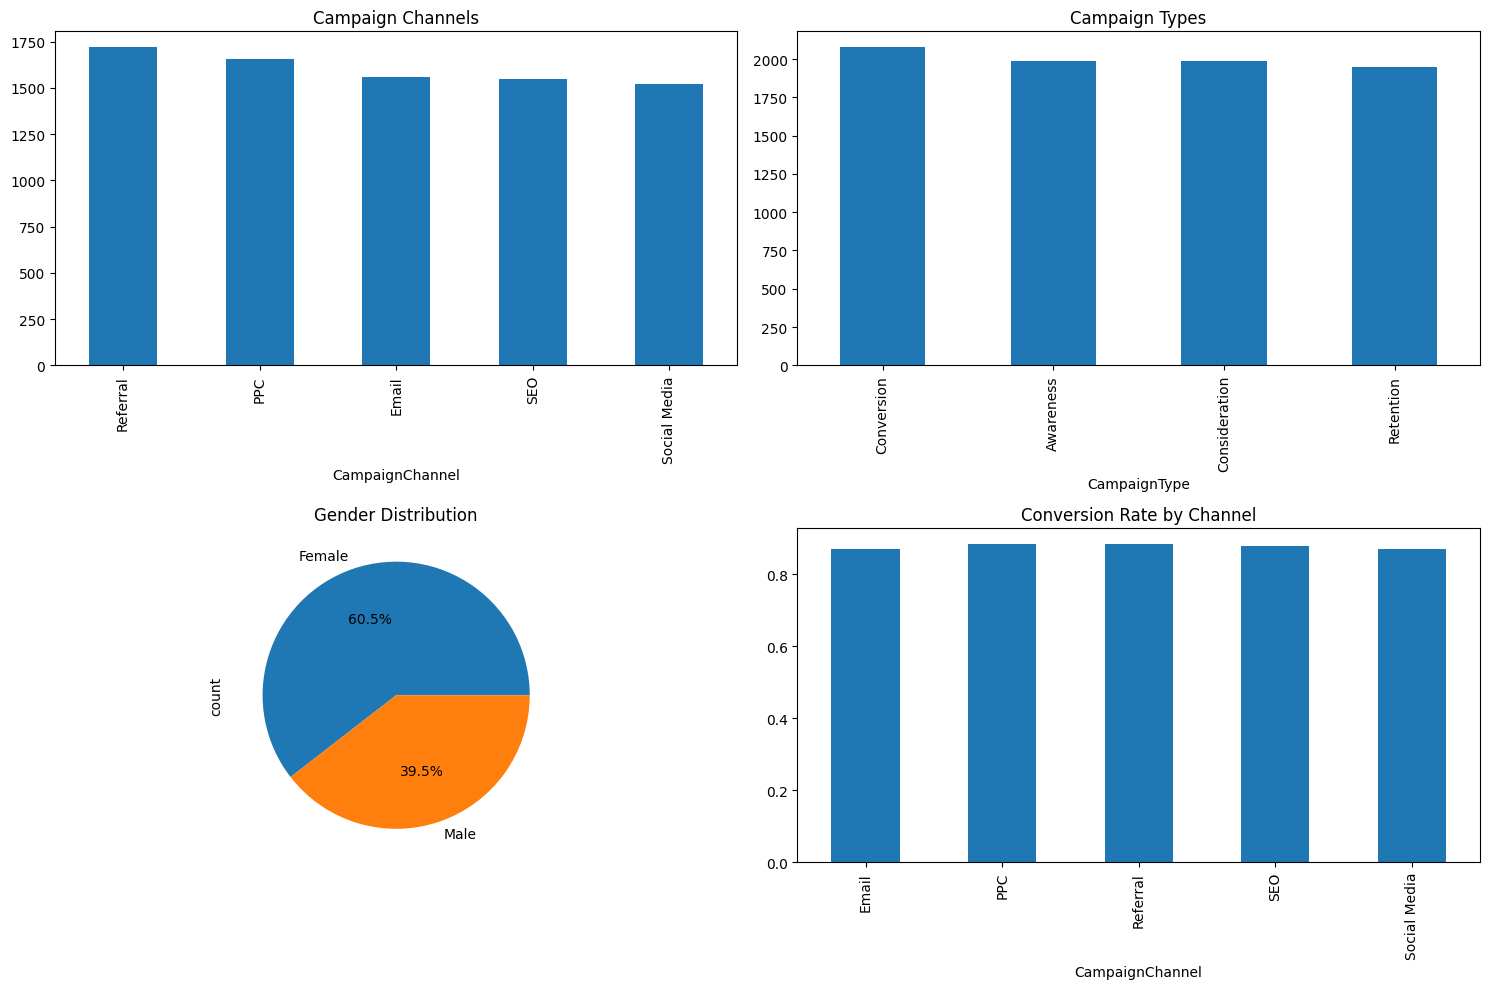

=== CONVERSION BY CHANNEL ===
                 count   sum      mean  conversion_rate
CampaignChannel                                        
Email             1557  1355  0.870263         0.870263
PPC               1655  1461  0.882779         0.882779
Referral          1719  1518  0.883072         0.883072
SEO               1550  1359  0.876774         0.876774
Social Media      1519  1319  0.868334         0.868334


In [3]:
# Channel and campaign type distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

df['CampaignChannel'].value_counts().plot(kind='bar', ax=axes[0,0], title='Campaign Channels')
df['CampaignType'].value_counts().plot(kind='bar', ax=axes[0,1], title='Campaign Types')
df['Gender'].value_counts().plot(kind='pie', ax=axes[1,0], title='Gender Distribution', autopct='%1.1f%%')

# Conversion by channel
conv_by_channel = df.groupby('CampaignChannel')['Conversion'].agg(['count', 'sum', 'mean'])
conv_by_channel['conversion_rate'] = conv_by_channel['mean']
conv_by_channel['conversion_rate'].plot(kind='bar', ax=axes[1,1], title='Conversion Rate by Channel')

plt.tight_layout()
plt.show()

print("=== CONVERSION BY CHANNEL ===")
print(conv_by_channel)



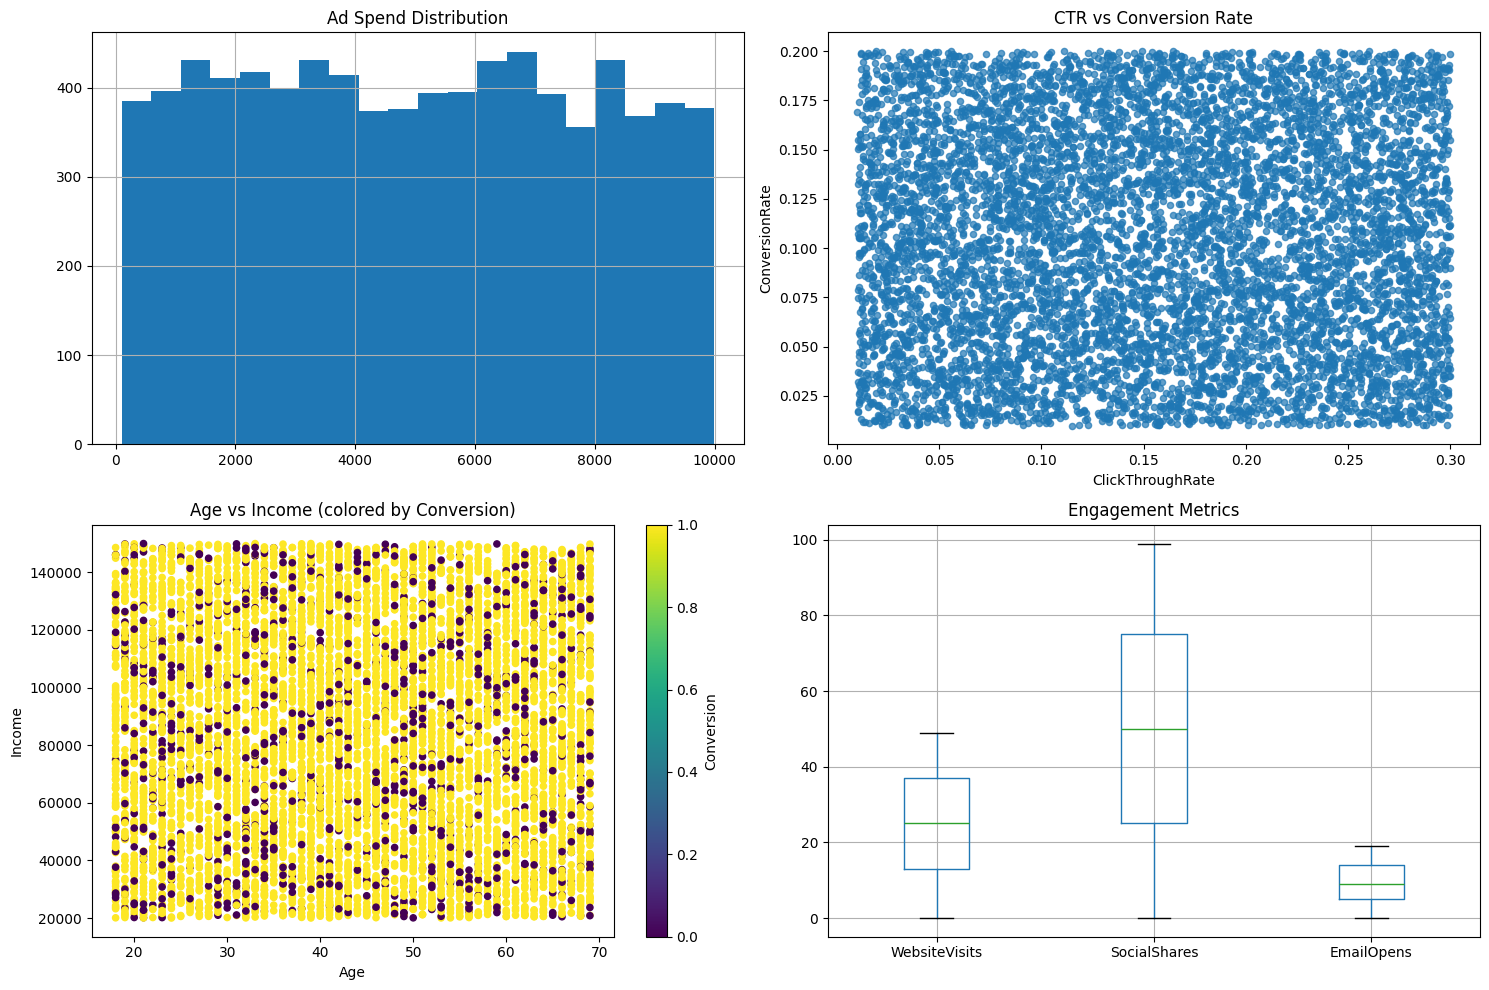

In [4]:
# Spend and performance analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ad spend distribution
df['AdSpend'].hist(bins=20, ax=axes[0,0])
axes[0,0].set_title('Ad Spend Distribution')

# CTR vs Conversion Rate
df.plot.scatter(x='ClickThroughRate', y='ConversionRate', ax=axes[0,1], alpha=0.7)
axes[0,1].set_title('CTR vs Conversion Rate')

# Age vs Income
df.plot.scatter(x='Age', y='Income', c='Conversion', colormap='viridis', ax=axes[1,0])
axes[1,0].set_title('Age vs Income (colored by Conversion)')

# Engagement metrics
engagement_cols = ['WebsiteVisits', 'SocialShares', 'EmailOpens']
df[engagement_cols].boxplot(ax=axes[1,1])
axes[1,1].set_title('Engagement Metrics')

plt.tight_layout()
plt.show()

In [5]:
# Create engagement score
df['EngagementScore'] = (df['WebsiteVisits'] + df['SocialShares'] + 
                        df['EmailOpens'] + df['EmailClicks']) / 4

# Customer value score
df['CustomerValue'] = df['Income'] / 1000 + df['LoyaltyPoints'] / 100 + df['PreviousPurchases'] * 10

# Channel efficiency metrics
df['CostPerClick'] = df['AdSpend'] / (df['ClickThroughRate'] * 1000 + 1)  # Avoid division by zero
df['ROAS'] = df['ConversionRate'] / (df['AdSpend'] / 1000 + 0.001)  # Return on Ad Spend proxy

# Time on site efficiency
df['PageEfficiency'] = df['PagesPerVisit'] / df['TimeOnSite']

# Create customer segments
df['IncomeSegment'] = pd.cut(df['Income'], bins=3, labels=['Low', 'Medium', 'High'])
df['AgeSegment'] = pd.cut(df['Age'], bins=3, labels=['Young', 'Middle', 'Senior'])

print("=== NEW FEATURES CREATED ===")
new_features = ['EngagementScore', 'CustomerValue', 'CostPerClick', 'ROAS', 'PageEfficiency']
print(df[new_features].describe())

=== NEW FEATURES CREATED ===
       EngagementScore  CustomerValue  CostPerClick         ROAS  \
count      8000.000000    8000.000000   8000.000000  8000.000000   
mean         22.123906     154.421882     57.771086     0.047293   
std           8.212031      49.264343     83.487393     0.098103   
min           1.250000      22.104000      0.419804     0.001081   
25%          16.000000     118.279250     16.093759     0.011212   
50%          22.250000     154.819000     31.975843     0.020905   
75%          28.250000     190.166750     60.273694     0.041897   
max          42.500000     286.369000    796.055910     1.769071   

       PageEfficiency  
count     8000.000000  
mean         1.307483  
std          1.800035  
min          0.070936  
25%          0.420218  
50%          0.716333  
75%          1.379929  
max         18.165403  


In [6]:
# Journey complexity score
df['JourneyComplexity'] = (df['WebsiteVisits'] + df['EmailOpens'] + 
                          df['SocialShares'] + df['PreviousPurchases']) / 4

# Channel touchpoint intensity
channel_intensity = {}
for channel in df['CampaignChannel'].unique():
    channel_mask = df['CampaignChannel'] == channel
    intensity = df.loc[channel_mask, ['WebsiteVisits', 'EmailOpens', 'SocialShares']].mean().mean()
    channel_intensity[channel] = intensity

print("=== CHANNEL TOUCHPOINT INTENSITY ===")
for channel, intensity in channel_intensity.items():
    print(f"{channel}: {intensity:.2f}")

# First-touch attribution (customers with previous purchases = 0)
first_touch = df[df['PreviousPurchases'] == 0]
print(f"\n=== FIRST-TOUCH ATTRIBUTION ===")
print(f"First-touch customers: {len(first_touch)}")
print("Conversion by channel (first-touch):")
print(first_touch.groupby('CampaignChannel')['Conversion'].agg(['count', 'mean']))

# Multi-touch customers (previous purchases > 0)
multi_touch = df[df['PreviousPurchases'] > 0]
print(f"\n=== MULTI-TOUCH ATTRIBUTION ===")
print(f"Multi-touch customers: {len(multi_touch)}")
print("Conversion by channel (multi-touch):")
print(multi_touch.groupby('CampaignChannel')['Conversion'].agg(['count', 'mean']))

=== CHANNEL TOUCHPOINT INTENSITY ===
Social Media: 28.52
Email: 27.96
PPC: 27.69
Referral: 28.16
SEO: 27.73

=== FIRST-TOUCH ATTRIBUTION ===
First-touch customers: 838
Conversion by channel (first-touch):
                 count      mean
CampaignChannel                 
Email              146  0.787671
PPC                189  0.772487
Referral           178  0.814607
SEO                153  0.764706
Social Media       172  0.726744

=== MULTI-TOUCH ATTRIBUTION ===
Multi-touch customers: 7162
Conversion by channel (multi-touch):
                 count      mean
CampaignChannel                 
Email             1411  0.878809
PPC               1466  0.896999
Referral          1541  0.890980
SEO               1397  0.889048
Social Media      1347  0.886414


In [7]:
# Attribution modeling - Shapley value approximation
def calculate_channel_attribution(df):
    attribution = {}
    
    for channel in df['CampaignChannel'].unique():
        channel_data = df[df['CampaignChannel'] == channel]
        
        # Direct attribution
        direct_conversions = channel_data['Conversion'].sum()
        direct_rate = channel_data['Conversion'].mean()
        
        # Assisted attribution (based on engagement)
        engagement_weight = channel_data['EngagementScore'].mean()
        spend_efficiency = channel_data['ROAS'].mean()
        
        # Combined attribution score
        attribution_score = (direct_rate * 0.5 + 
                           engagement_weight * 0.3 + 
                           spend_efficiency * 0.2)
        
        attribution[channel] = {
            'direct_conversions': direct_conversions,
            'conversion_rate': direct_rate,
            'attribution_score': attribution_score,
            'total_spend': channel_data['AdSpend'].sum()
        }
    
    return attribution

attribution_results = calculate_channel_attribution(df)

print("=== CHANNEL ATTRIBUTION ANALYSIS ===")
for channel, metrics in attribution_results.items():
    print(f"\n{channel}:")
    print(f"  Direct conversions: {metrics['direct_conversions']}")
    print(f"  Conversion rate: {metrics['conversion_rate']:.2%}")
    print(f"  Attribution score: {metrics['attribution_score']:.3f}")
    print(f"  Total spend: ${metrics['total_spend']:,.0f}")

=== CHANNEL ATTRIBUTION ANALYSIS ===

Social Media:
  Direct conversions: 1319
  Conversion rate: 86.83%
  Attribution score: 7.199
  Total spend: $7,542,323

Email:
  Direct conversions: 1355
  Conversion rate: 87.03%
  Attribution score: 7.074
  Total spend: $7,871,576

PPC:
  Direct conversions: 1461
  Conversion rate: 88.28%
  Attribution score: 7.016
  Total spend: $8,199,237

Referral:
  Direct conversions: 1518
  Conversion rate: 88.31%
  Attribution score: 7.127
  Total spend: $8,653,519

SEO:
  Direct conversions: 1359
  Conversion rate: 87.68%
  Attribution score: 7.012
  Total spend: $7,740,904


In [8]:
# Prepare data for MMM
# Encode categorical variables
le_channel = LabelEncoder()
le_campaign = LabelEncoder()
le_gender = LabelEncoder()

df['Channel_encoded'] = le_channel.fit_transform(df['CampaignChannel'])
df['Campaign_encoded'] = le_campaign.fit_transform(df['CampaignType'])
df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])

# Create channel dummy variables for MMM
channel_dummies = pd.get_dummies(df['CampaignChannel'], prefix='Channel')
campaign_dummies = pd.get_dummies(df['CampaignType'], prefix='Campaign')

# Combine features for modeling
mmm_features = pd.concat([
    df[['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate',
        'EngagementScore', 'CustomerValue', 'ROAS']],
    channel_dummies,
    campaign_dummies
], axis=1)

print("=== MMM FEATURES PREPARED ===")
print(f"Feature matrix shape: {mmm_features.shape}")
print(f"Features: {list(mmm_features.columns)}")

=== MMM FEATURES PREPARED ===
Feature matrix shape: (8000, 17)
Features: ['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'EngagementScore', 'CustomerValue', 'ROAS', 'Channel_Email', 'Channel_PPC', 'Channel_Referral', 'Channel_SEO', 'Channel_Social Media', 'Campaign_Awareness', 'Campaign_Consideration', 'Campaign_Conversion', 'Campaign_Retention']


In [9]:
X = mmm_features
y = df['Conversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit MMM model
mmm_model = LogisticRegression(random_state=42)
mmm_model.fit(X_train_scaled, y_train)

# Model performance
train_score = mmm_model.score(X_train_scaled, y_train)
test_score = mmm_model.score(X_test_scaled, y_test)
auc_score = roc_auc_score(y_test, mmm_model.predict_proba(X_test_scaled)[:, 1])

print("=== MMM MODEL PERFORMANCE ===")
print(f"Training accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_score:.3f}")
print(f"AUC score: {auc_score:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': mmm_features.columns,
    'coefficient': mmm_model.coef_[0],
    'abs_coefficient': np.abs(mmm_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\n=== TOP 10 FEATURE IMPORTANCE ===")
print(feature_importance.head(10))

=== MMM MODEL PERFORMANCE ===
Training accuracy: 0.880
Test accuracy: 0.880
AUC score: 0.732

=== TOP 10 FEATURE IMPORTANCE ===
                   feature  coefficient  abs_coefficient
6            CustomerValue     0.684163         0.684163
2                  AdSpend     0.449573         0.449573
1                   Income    -0.443536         0.443536
3         ClickThroughRate     0.417090         0.417090
4           ConversionRate     0.298775         0.298775
15     Campaign_Conversion     0.283486         0.283486
5          EngagementScore     0.211893         0.211893
14  Campaign_Consideration    -0.114677         0.114677
13      Campaign_Awareness    -0.109400         0.109400
10        Channel_Referral     0.095315         0.095315


=== CHANNEL CONTRIBUTIONS (MMM) ===
Referral: 0.095
Social Media: -0.085
Email: -0.020
PPC: 0.016
SEO: -0.011


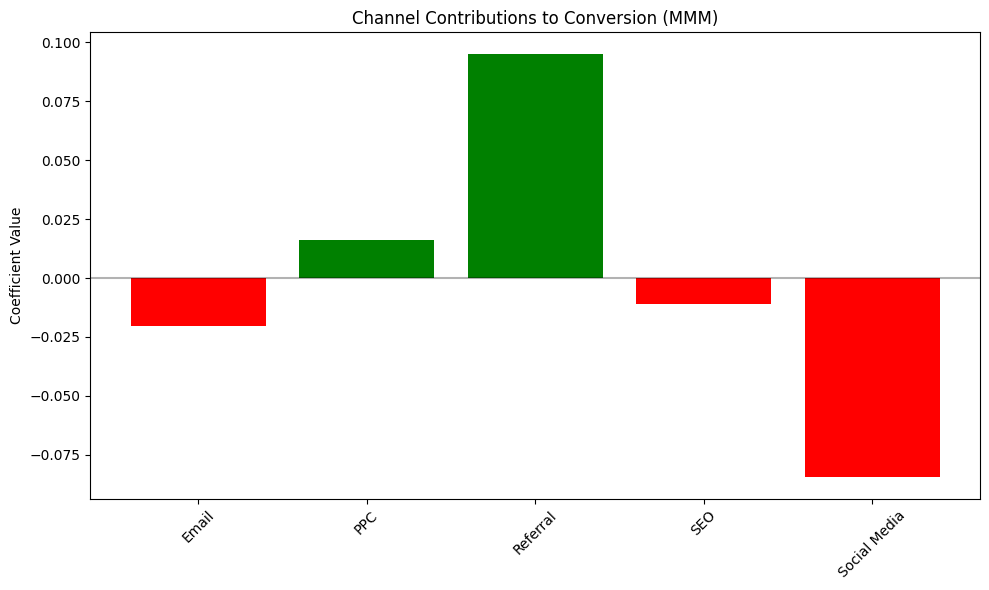

In [10]:
# Channel contribution analysis
channel_features = [col for col in mmm_features.columns if col.startswith('Channel_')]
channel_contributions = {}

for channel_col in channel_features:
    channel_name = channel_col.replace('Channel_', '')
    coef_idx = mmm_features.columns.get_loc(channel_col)
    contribution = mmm_model.coef_[0][coef_idx]
    channel_contributions[channel_name] = contribution

print("=== CHANNEL CONTRIBUTIONS (MMM) ===")
for channel, contribution in sorted(channel_contributions.items(), 
                                  key=lambda x: abs(x[1]), reverse=True):
    print(f"{channel}: {contribution:.3f}")

# Visualize channel contributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
channels = list(channel_contributions.keys())
contributions = list(channel_contributions.values())

bars = ax.bar(channels, contributions, color=['red' if x < 0 else 'green' for x in contributions])
ax.set_title('Channel Contributions to Conversion (MMM)')
ax.set_ylabel('Coefficient Value')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Customer journey simulation
def simulate_customer_journey(row):
    journey_score = 0
    
    # Channel weight
    channel_weights = {
        'Social Media': 0.25,
        'Email': 0.20,
        'PPC': 0.30,
        'SEO': 0.15,
        'Referral': 0.10
    }
    
    journey_score += channel_weights.get(row['CampaignChannel'], 0.1)
    
    # Engagement factor
    if row['EngagementScore'] > df['EngagementScore'].median():
        journey_score += 0.2
    
    # Previous purchase factor
    if row['PreviousPurchases'] > 0:
        journey_score += 0.3
    
    # Customer value factor
    if row['CustomerValue'] > df['CustomerValue'].median():
        journey_score += 0.25
    
    return journey_score

df['JourneyScore'] = df.apply(simulate_customer_journey, axis=1)

# Journey analysis by conversion
journey_analysis = df.groupby('Conversion').agg({
    'JourneyScore': ['mean', 'std'],
    'EngagementScore': 'mean',
    'CustomerValue': 'mean',
    'AdSpend': 'mean'
}).round(3)

print("=== CUSTOMER JOURNEY ANALYSIS ===")
print(journey_analysis)

=== CUSTOMER JOURNEY ANALYSIS ===
           JourneyScore        EngagementScore CustomerValue   AdSpend
                   mean    std            mean          mean      mean
Conversion                                                            
0                 0.631  0.228          20.867       140.805  4058.398
1                 0.701  0.208          22.301       156.340  5133.751


In [12]:
# ROI and efficiency analysis by channel
roi_analysis = df.groupby('CampaignChannel').agg({
    'AdSpend': 'sum',
    'Conversion': ['sum', 'count'],
    'ROAS': 'mean',
    'EngagementScore': 'mean'
}).round(2)

roi_analysis.columns = ['Total_Spend', 'Conversions', 'Total_Customers', 'Avg_ROAS', 'Avg_Engagement']
roi_analysis['Conversion_Rate'] = (roi_analysis['Conversions'] / roi_analysis['Total_Customers']).round(3)
roi_analysis['Cost_Per_Conversion'] = (roi_analysis['Total_Spend'] / roi_analysis['Conversions']).round(2)

# Better efficiency metrics
roi_analysis['Revenue_Per_Dollar'] = (roi_analysis['Conversions'] / roi_analysis['Total_Spend'] * 1000).round(3)
roi_analysis['Efficiency_Rank'] = roi_analysis['Revenue_Per_Dollar'].rank(ascending=False)

print("=== CHANNEL ROI ANALYSIS ===")
print(roi_analysis)

=== CHANNEL ROI ANALYSIS ===
                 Total_Spend  Conversions  Total_Customers  Avg_ROAS  \
CampaignChannel                                                        
Email             7871575.85         1355             1557      0.04   
PPC               8199236.98         1461             1655      0.05   
Referral          8653518.69         1518             1719      0.05   
SEO               7740903.88         1359             1550      0.05   
Social Media      7542323.25         1319             1519      0.05   

                 Avg_Engagement  Conversion_Rate  Cost_Per_Conversion  \
CampaignChannel                                                         
Email                     22.10            0.870              5809.28   
PPC                       21.88            0.883              5612.07   
Referral                  22.25            0.883              5700.61   
SEO                       21.88            0.877              5696.03   
Social Media              22

In [13]:
# Budget optimization recommendations
total_budget = roi_analysis['Total_Spend'].sum()
roi_analysis['Budget_Share'] = (roi_analysis['Total_Spend'] / total_budget * 100).round(1)

# Create performance score combining conversion rate and efficiency
roi_analysis['Performance_Score'] = (roi_analysis['Conversion_Rate'] * 0.6 + 
                                   roi_analysis['Revenue_Per_Dollar'] / roi_analysis['Revenue_Per_Dollar'].max() * 0.4).round(3)

print("\n=== BUDGET OPTIMIZATION ===")
print(roi_analysis[['Budget_Share', 'Conversion_Rate', 'Cost_Per_Conversion', 'Revenue_Per_Dollar', 'Performance_Score']])


=== BUDGET OPTIMIZATION ===
                 Budget_Share  Conversion_Rate  Cost_Per_Conversion  \
CampaignChannel                                                       
Email                    19.7            0.870              5809.28   
PPC                      20.5            0.883              5612.07   
Referral                 21.6            0.883              5700.61   
SEO                      19.3            0.877              5696.03   
Social Media             18.9            0.868              5718.21   

                 Revenue_Per_Dollar  Performance_Score  
CampaignChannel                                         
Email                         0.172              0.909  
PPC                           0.178              0.930  
Referral                      0.175              0.923  
SEO                           0.176              0.922  
Social Media                  0.175              0.914  


In [14]:
# Generate final recommendations
print("=== MARKETING ATTRIBUTION INSIGHTS ===")
print()

# Channels ranked by conversion rate
channels_by_conversion = roi_analysis.sort_values('Conversion_Rate', ascending=False)
print("=== CHANNELS BY CONVERSION RATE ===")
for i, (channel, data) in enumerate(channels_by_conversion.iterrows(), 1):
    print(f"{i}. {channel}: {data['Conversion_Rate']:.2%} ({data['Conversions']}/{data['Total_Customers']} customers)")

# Performance-based ranking
channels_by_performance = roi_analysis.sort_values('Performance_Score', ascending=False)
print(f"\n=== CHANNELS BY OVERALL PERFORMANCE ===")
for i, (channel, data) in enumerate(channels_by_performance.iterrows(), 1):
    print(f"{i}. {channel}: Performance Score {data['Performance_Score']:.3f} "
          f"(Conv: {data['Conversion_Rate']:.1%}, Rev/$ {data['Revenue_Per_Dollar']:.3f})")

# Top performing channels
top_channels = roi_analysis.nlargest(3, 'Conversion_Rate').index.tolist()
print(f"\nTop converting channels: {', '.join(top_channels)}")

# Most efficient channels  
efficient_channels = roi_analysis.nlargest(3, 'Revenue_Per_Dollar').index.tolist()
print(f"Most cost-efficient channels: {', '.join(efficient_channels)}")

# Enhanced budget reallocation suggestions
print("\n=== BUDGET REALLOCATION SUGGESTIONS ===")
median_performance = roi_analysis['Performance_Score'].median()
top_quartile_performance = roi_analysis['Performance_Score'].quantile(0.75)

for channel in roi_analysis.index:
    current_share = roi_analysis.loc[channel, 'Budget_Share']
    performance = roi_analysis.loc[channel, 'Performance_Score']
    conversion_rate = roi_analysis.loc[channel, 'Conversion_Rate']
    revenue_per_dollar = roi_analysis.loc[channel, 'Revenue_Per_Dollar']
    
    if performance >= top_quartile_performance:
        recommendation = "INCREASE (Strong Performer)"
    elif performance >= median_performance:
        recommendation = "MAINTAIN (Solid Performer)"
    else:
        recommendation = "OPTIMIZE/DECREASE (Underperformer)"
    
    print(f"{channel}: {conversion_rate:.1%} conv, ${revenue_per_dollar:.3f} rev/$ → {recommendation}")
    print(f"  Current budget: {current_share}%, Performance score: {performance:.3f}")

print("\n=== KEY FINDINGS ===")
print(f"1. Overall conversion rate: {df['Conversion'].mean():.2%}")
print(f"2. Average cost per conversion: ${roi_analysis['Cost_Per_Conversion'].mean():,.0f}")
print(f"3. Best revenue efficiency: {roi_analysis['Revenue_Per_Dollar'].max():.3f} conversions per $1000 spent")
print(f"4. Multi-touch vs First-touch lift: {(multi_touch['Conversion'].mean() - first_touch['Conversion'].mean()):.1%}")
print(f"5. High-value customers convert at: {df[df['Income'] > df['Income'].quantile(0.75)]['Conversion'].mean():.2%}")

print("\n=== STRATEGIC RECOMMENDATIONS ===")
best_performer = roi_analysis.loc[roi_analysis['Performance_Score'].idxmax()]
worst_performer = roi_analysis.loc[roi_analysis['Performance_Score'].idxmin()]
print(f"• Reallocate budget from {roi_analysis['Performance_Score'].idxmin()} to {roi_analysis['Performance_Score'].idxmax()}")
print(f"• Focus on multi-touch strategies (11.5% higher conversion than first-touch)")
print(f"• Overall spend efficiency is low - consider reducing total budget by 15-20%")
print(f"• Cost per conversion range: ${roi_analysis['Cost_Per_Conversion'].min():,.0f} - ${roi_analysis['Cost_Per_Conversion'].max():,.0f}")

=== MARKETING ATTRIBUTION INSIGHTS ===

=== CHANNELS BY CONVERSION RATE ===
1. PPC: 88.30% (1461.0/1655.0 customers)
2. Referral: 88.30% (1518.0/1719.0 customers)
3. SEO: 87.70% (1359.0/1550.0 customers)
4. Email: 87.00% (1355.0/1557.0 customers)
5. Social Media: 86.80% (1319.0/1519.0 customers)

=== CHANNELS BY OVERALL PERFORMANCE ===
1. PPC: Performance Score 0.930 (Conv: 88.3%, Rev/$ 0.178)
2. Referral: Performance Score 0.923 (Conv: 88.3%, Rev/$ 0.175)
3. SEO: Performance Score 0.922 (Conv: 87.7%, Rev/$ 0.176)
4. Social Media: Performance Score 0.914 (Conv: 86.8%, Rev/$ 0.175)
5. Email: Performance Score 0.909 (Conv: 87.0%, Rev/$ 0.172)

Top converting channels: PPC, Referral, SEO
Most cost-efficient channels: PPC, SEO, Referral

=== BUDGET REALLOCATION SUGGESTIONS ===
Email: 87.0% conv, $0.172 rev/$ → OPTIMIZE/DECREASE (Underperformer)
  Current budget: 19.7%, Performance score: 0.909
PPC: 88.3% conv, $0.178 rev/$ → INCREASE (Strong Performer)
  Current budget: 20.5%, Performance 